# Introduction

# Importing libraries 

In [1]:
import pandas as pd
import polars as pl
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data Processing

In [2]:
telco_data = pl.read_csv("/Users/ryanquach/Downloads/telco-customer-churn.csv")

dummy_var = ( 
    telco_data
    .select(pl.exclude([pl.Int64, pl.Float64]))
    .select(pl.exclude("customerID"))
    .columns
)


telco_data = telco_data.to_pandas()
telco_data = pd.get_dummies(telco_data, columns = dummy_var, drop_first = True)

In [3]:
telco_data = (
    pl.from_pandas(telco_data)
    .select(pl.exclude("customerID"))
)

telco_data.head(n = 10)

SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
i64,i64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
0,34,56.95,1889.5,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
0,2,53.85,108.15,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
0,45,42.3,1840.75,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
0,2,70.7,151.65,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
0,8,99.65,820.5,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1
0,22,89.1,1949.4,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
0,10,29.75,301.9,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0,28,104.8,3046.05,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1


# Class imbalance of target variable

In [4]:
(telco_data
     .groupby("Churn_Yes")
     .agg(pl.count()/len(telco_data))
)

Churn_Yes,count
u8,f64
0,0.73463
1,0.26537


# Model building

In [5]:
mod_xgb = XGBClassifier()

X = telco_data.select(pl.exclude("Churn_Yes")).to_numpy()
Y = telco_data.select(pl.col("Churn_Yes")).to_numpy()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 421)

mod_xgb.fit(x_train, y_train)
y_pred = mod_xgb.predict(x_test)

# Model accuracy

In [6]:
round(accuracy_score(y_test, y_pred), 2)

0.78

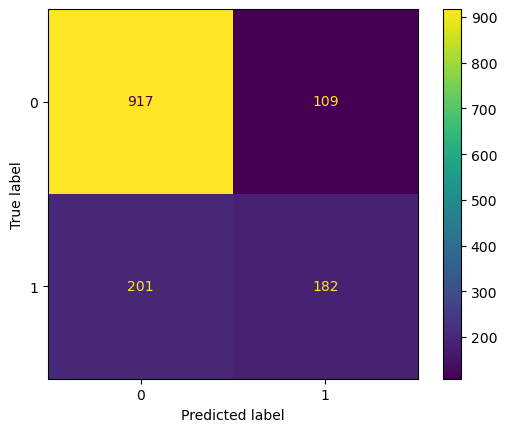

In [7]:
cm = confusion_matrix(y_test, y_pred)
cm_graphic = ConfusionMatrixDisplay(cm)
cm_graphic.plot()

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1026
           1       0.63      0.48      0.54       383

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



# Implications

The most important implication of this process is that we have created a model that generates actual business value in the context of telecommunication sales. To explain, in the original dataset, about 73% of the individuals actually stayed with the company plan, thereby counting as a 0 for the churn variable. In contrast, our model has a specificity of 89%, meaning that among all individuals who were actually continuing to be a customer, 89% of them were correctly predicted as such. 

Therefore, given that the precision is also quite high, one would be able to apply this gradient boosting model for the purpose of increasing customer churn. In order to evaluate the actual value of this model, we will calculate the value of the average plan.

In [9]:
telco_data.select(pl.mean("MonthlyCharges"))

MonthlyCharges
f64
64.761692


As one can see, the average monthly cost of the company's plans is \\$64.76, which is \\$777.12 annually. Now, that this value been found, we can now determine the actual business value of our modeling efforts. 

For every ten thousand customers that make an initial purchase of the telecommunications plan, 1600 more customers would continue doing business with the company than compared to the status quo, as shown by the previously presented confusion matrix. Under the assumption that these customers would stay on these plans for the whole year, it is estimated that this increase in usage would provide $1,243,392 in annual business value. And this value would only increase once one takes into account the scale of the telecommunications company, which most likely supports millions of customers with its services. 